In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import os 
import itertools 
import uproot
import time
import awkward as ak
from IPython.display import display, HTML
import hist
#import vector
import pickle
import matplotlib.pyplot as plt

import xgboost
print(xgboost.__version__)
import sklearn
print (sklearn.__version__)

1.7.3
0.23.2


## Load datasets and concatenate

In [2]:
#Set to read all columns
pd.set_option('display.max_columns', None)

#Import and concatenate the training sets
df_bkg = pd.read_csv('bkg_train.csv')
#df_sig = pd.read_csv('sig_train_barrel.csv')     #no z removed
#df_sig = pd.read_csv('sig_train_barrel_z_adjusted_all.csv')   #all z>10m removed
df_sig = pd.read_csv('sig_train_barrel_z_adjusted_eta.csv')   #some z>10m removed (eta-dependent...see model_analysis.html)


df = pd.concat([df_bkg,df_sig], ignore_index=True)
#df = pd.read_csv('sig_train_barrel.csv')

In [3]:
#Slice eta at veto region
df = df[(abs(df['Vtx_eta']) < 0.7) | (abs(df['Vtx_eta']) > 1.3)]

## Begin Training

In [4]:
#Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

In [5]:
#Check columns of df
df.columns

Index(['Event #', 'Mult', 'MDT', 'RPC', 'TGC', 'ntrks', 'Vtx_eta', 'Vtx_phi',
       'Vtx_Sum_pT', 'jet_pt_1', 'jet_eta_1', 'jet_phi_1', 'jet_logRatio_1',
       'jet_jvt_1', 'delta_jet_1', 'jet_pt_2', 'jet_eta_2', 'jet_phi_2',
       'jet_logRatio_2', 'jet_jvt_2', 'delta_jet_2', 'jet_pt_3', 'jet_eta_3',
       'jet_phi_3', 'jet_logRatio_3', 'jet_jvt_3', 'delta_jet_3', 'track_pt_1',
       'delta_track_1', 'track_pt_2', 'delta_track_2', 'track_pt_3',
       'delta_track_3', 'Label'],
      dtype='object')

In [6]:
#Delcare Target
#WARNING : there should be no selection nor shuffling later on ! (otherwise misalignement)
target = df["Label"]

In [7]:
# For simplicity only keep some most important features. Can add more later down below
data=pd.DataFrame(df, columns=['Mult','ntrks','Vtx_eta','Vtx_phi','Vtx_Sum_pT','jet_pt_1','jet_eta_1','jet_phi_1','delta_jet_1','track_pt_1','delta_track_1'])

print ("Df shape of dataset to be used :",data.shape)
display(data.head())
display(target.head())


Df shape of dataset to be used : (13644, 11)


,Mult,ntrks,Vtx_eta,Vtx_phi,Vtx_Sum_pT,jet_pt_1,jet_eta_1,jet_phi_1,delta_jet_1,track_pt_1,delta_track_1
0,1.0,3,-1.397776,0.147975,3758.759567,1049.524875,-1.456594,0.101225,0.005645,1.067293,0.001557
1,1.0,3,-1.601971,-1.649671,4111.351961,1065.463875,-1.559294,-1.699862,0.004340,34.648298,0.001035
2,1.0,4,-0.699745,-0.684429,984.970927,22.774982,-0.594920,-1.192868,0.269498,0.984971,0.035367
3,1.0,6,2.129160,-0.239560,0.000000,26.833268,2.607839,-0.239011,0.229134,0.720324,0.125680
4,1.0,4,1.492455,-0.586702,3144.816739,1307.769750,1.504384,-0.622236,0.001405,9.363345,0.000407


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Label, dtype: float64

In [8]:
more_features = False
if (more_features):
    data=pd.DataFrame(df, columns=['Event #', 'Mult', 'MDT', 'RPC', 'TGC', 'ntrks', 'Vtx_eta', 'Vtx_phi',
       'Vtx_Sum_pT', 'Label', 'jet_pt_1', 'jet_eta_1', 'jet_phi_1',
       'jet_logRatio_1', 'jet_jvt_1', 'delta_jet_1', 'jet_pt_2', 'jet_eta_2',
       'jet_phi_2', 'jet_logRatio_2', 'jet_jvt_2', 'delta_jet_2', 'track_pt_1',
       'delta_track_1', 'track_pt_2', 'delta_track_2', 'track_pt_3','delta_track_3'])
print ("Df shape of dataset to be used :",data.shape)

Df shape of dataset to be used : (13644, 11)


### PreProcess the data

In [9]:
#np.random.seed(31415)

from sklearn.model_selection import train_test_split
train_size = 0.75 # fraction of sample used for training

X_train, X_test, y_train, y_test, = train_test_split(data, target, train_size=train_size)

#Reset index for dataseries, not needed for ndarray (X_train, X_test)
#Basically just re-adding the original element indexing from pandas
y_train, y_test = \
    y_train.reset_index(drop=True),y_test.reset_index(drop=True)

print ("X_train shape:",X_train.shape)
print ("y_train shape:",y_train.shape)


print ("X_test shape:",X_test.shape)
print ("y_test shape:",y_test.shape)


X_train shape: (10233, 11)
y_train shape: (10233,)
X_test shape: (3411, 11)
y_test shape: (3411,)


### Train the BDT

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

np.random.seed(31415)  # set the random seed

xgb = XGBClassifier(tree_method="hist", use_label_encoder=False, eval_metric='logloss')

# Monitor training loss and validation loss
eval_set = [(X_train, y_train), (X_test, y_test)]

# Fit the model with evaluation data for monitoring
starting_time = time.time()

xgb.fit(X_train, 
        y_train.values, 
        eval_set=eval_set, 
        verbose=True)  # verbose=True prints loss per epoch

training_time = time.time() - starting_time
print("Training time:", training_time)

# Prediction on test data by trained BDT classifier
y_pred_xgb = xgb.predict_proba(X_test)[:, 1].ravel()

# Prediction on train data by BDT classifier
y_pred_train_xgb = xgb.predict_proba(X_train)[:, 1].ravel()

auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb)
print("auc test:", auc_test_xgb)
print("auc train:", roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb), "\n")


[0]	validation_0-logloss:0.47904	validation_1-logloss:0.48712
[1]	validation_0-logloss:0.36093	validation_1-logloss:0.37430
[2]	validation_0-logloss:0.28581	validation_1-logloss:0.30355
[3]	validation_0-logloss:0.23668	validation_1-logloss:0.25790
[4]	validation_0-logloss:0.20311	validation_1-logloss:0.22786
[5]	validation_0-logloss:0.17965	validation_1-logloss:0.20736
[6]	validation_0-logloss:0.16298	validation_1-logloss:0.19416
[7]	validation_0-logloss:0.15063	validation_1-logloss:0.18448
[8]	validation_0-logloss:0.14185	validation_1-logloss:0.17768


/Users/christopheralpert/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[9]	validation_0-logloss:0.13436	validation_1-logloss:0.17337
[10]	validation_0-logloss:0.12954	validation_1-logloss:0.17021
[11]	validation_0-logloss:0.12566	validation_1-logloss:0.16785
[12]	validation_0-logloss:0.12184	validation_1-logloss:0.16636
[13]	validation_0-logloss:0.11948	validation_1-logloss:0.16492
[14]	validation_0-logloss:0.11702	validation_1-logloss:0.16451
[15]	validation_0-logloss:0.11483	validation_1-logloss:0.16389
[16]	validation_0-logloss:0.11354	validation_1-logloss:0.16349
[17]	validation_0-logloss:0.11113	validation_1-logloss:0.16362
[18]	validation_0-logloss:0.10997	validation_1-logloss:0.16334
[19]	validation_0-logloss:0.10844	validation_1-logloss:0.16380
[20]	validation_0-logloss:0.10640	validation_1-logloss:0.16408
[21]	validation_0-logloss:0.10417	validation_1-logloss:0.16396
[22]	validation_0-logloss:0.10317	validation_1-logloss:0.16465
[23]	validation_0-logloss:0.10112	validation_1-logloss:0.16544
[24]	validation_0-logloss:0.10013	validation_1-logloss:0

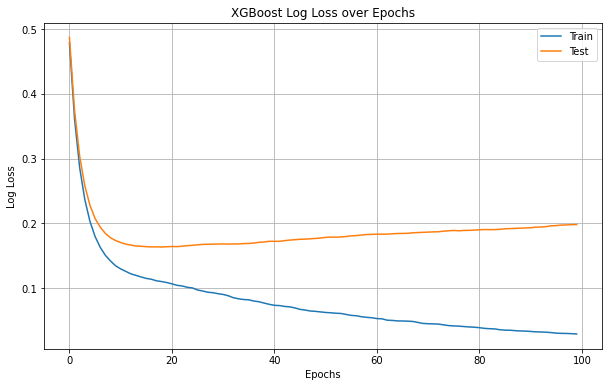

In [11]:
#Let's measure the training loss as a function of epochs

# Extract loss history
results = xgb.evals_result()

# Get training and validation loss history
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

# Plot log loss
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Test')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


## We can see that the loss is minimized around 12-15 epochs. Let's stop the training early and see if we can better
## the test score without taking too much of a hit on the training score

In [12]:
## Early Stopping


np.random.seed(31415)  # set the random seed

xgb = XGBClassifier(tree_method="hist", use_label_encoder=False, eval_metric='logloss')

# Monitor training loss and validation loss
eval_set = [(X_train, y_train), (X_test, y_test)]

# Fit the model with evaluation data for monitoring
starting_time = time.time()

xgb.fit(X_train, 
        y_train.values, 
        eval_set=eval_set, 
        early_stopping_rounds = 10,
        verbose=True)  # verbose=True prints loss per epoch

training_time = time.time() - starting_time
print("Training time:", training_time)

# Prediction on test data by trained BDT classifier
y_pred_xgb = xgb.predict_proba(X_test)[:, 1].ravel()

# Prediction on train data by BDT classifier
y_pred_train_xgb = xgb.predict_proba(X_train)[:, 1].ravel()

auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb)
print("auc test:", auc_test_xgb)
print("auc train:", roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb), "\n")

##This gave us a small increase in test score but at a much greater loss with the training score


[0]	validation_0-logloss:0.47904	validation_1-logloss:0.48712
[1]	validation_0-logloss:0.36093	validation_1-logloss:0.37430
[2]	validation_0-logloss:0.28581	validation_1-logloss:0.30355
[3]	validation_0-logloss:0.23668	validation_1-logloss:0.25790
[4]	validation_0-logloss:0.20311	validation_1-logloss:0.22786
[5]	validation_0-logloss:0.17965	validation_1-logloss:0.20736
[6]	validation_0-logloss:0.16298	validation_1-logloss:0.19416
[7]	validation_0-logloss:0.15063	validation_1-logloss:0.18448


/Users/christopheralpert/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/christopheralpert/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-logloss:0.14185	validation_1-logloss:0.17768
[9]	validation_0-logloss:0.13436	validation_1-logloss:0.17337
[10]	validation_0-logloss:0.12954	validation_1-logloss:0.17021
[11]	validation_0-logloss:0.12566	validation_1-logloss:0.16785
[12]	validation_0-logloss:0.12184	validation_1-logloss:0.16636
[13]	validation_0-logloss:0.11948	validation_1-logloss:0.16492
[14]	validation_0-logloss:0.11702	validation_1-logloss:0.16451
[15]	validation_0-logloss:0.11483	validation_1-logloss:0.16389
[16]	validation_0-logloss:0.11354	validation_1-logloss:0.16349
[17]	validation_0-logloss:0.11113	validation_1-logloss:0.16362
[18]	validation_0-logloss:0.10997	validation_1-logloss:0.16334
[19]	validation_0-logloss:0.10844	validation_1-logloss:0.16380
[20]	validation_0-logloss:0.10640	validation_1-logloss:0.16408
[21]	validation_0-logloss:0.10417	validation_1-logloss:0.16396
[22]	validation_0-logloss:0.10317	validation_1-logloss:0.16465
[23]	validation_0-logloss:0.10112	validation_1-logloss:0.

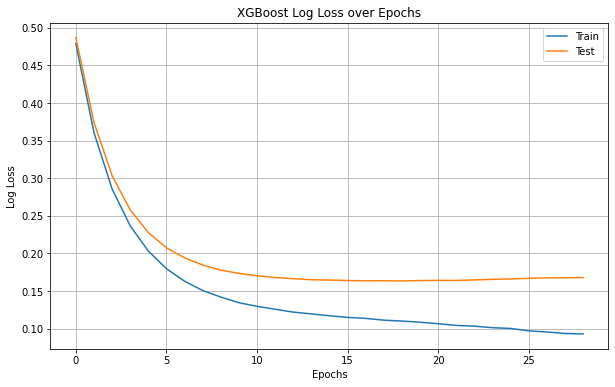

In [13]:
#Let's measure the training loss as a function of epochs

# Extract loss history
results = xgb.evals_result()

# Get training and validation loss history
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

# Plot log loss
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Test')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


## This offers a slight increase in performance, at the expense of training score. We can see the difference 
## between train and test loss start to deviate right around 27 epochs.